# Building regression models to predict dissolved inorganic carbon in water samples
#### Author: Linus Ghanadan

#### [Link to GitHub repository](https://github.com/linusghanadan/dic-ml-models)

## Background

In this blog post, I'll build three different models that predict **dissolved inorganic carbon (DIC)** content in water samples. The features being used to make these predictions will be other ocean chemistry measurements that were also measured during water sampling. Our data set comes from the **California Cooperative Oceanic Fisheries Investigations (CalCOFI)**, an oceanographic and marine ecosystem research program located in California ([link to data set source](https://calcofi.org/data/oceanographic-data/bottle-database/)). All water samples were taken off the California coast.

The first of the three models, which I'm including just for the sake of comparison, uses only a single decision tree. The other two models will be a random forest model and a stochastic gradient boosted (SGB) trees model.

## Setup

In [ ]:
import pandas as pd
import numpy as np

# functions from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Data import & basic pre-processing

In [56]:
# import training data
df = pd.read_csv('data/train.csv')

# inspect data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1454 non-null   int64  
 1   Lat_Dec            1454 non-null   float64
 2   Lon_Dec            1454 non-null   float64
 3   NO2uM              1454 non-null   float64
 4   NO3uM              1454 non-null   float64
 5   NH3uM              1454 non-null   float64
 6   R_TEMP             1454 non-null   float64
 7   R_Depth            1454 non-null   int64  
 8   R_Sal              1454 non-null   float64
 9   R_DYNHT            1454 non-null   float64
 10  R_Nuts             1454 non-null   float64
 11  R_Oxy_micromol.Kg  1454 non-null   float64
 12  Unnamed: 12        0 non-null      float64
 13  PO4uM              1454 non-null   float64
 14  SiO3uM             1454 non-null   float64
 15  TA1.x              1454 non-null   float64
 16  Salinity1          1454 

In [57]:
# remove 'id' and 'unnamed:_12' columns
df = df.drop(df.columns[[0, 12]], axis=1)

## Data exploration & additional pre-processing

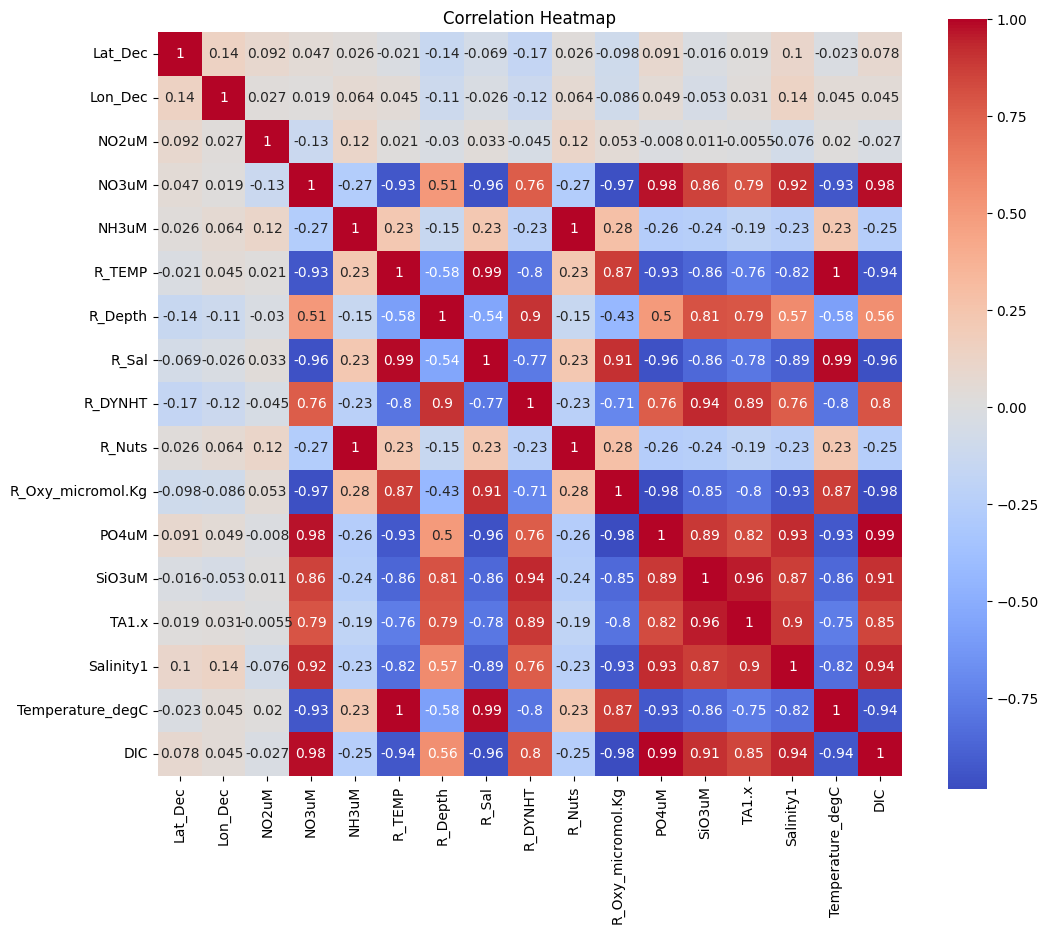

In [58]:
# heatmap of correlation between features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

I'll use this correlation heatmap to conduct feature selection, removing features that are highly correlated with other features. Specifically, I'll remove 'Temperature_degC' (correlation with 'R_TEMP' is 1) and  'R_Nuts' (correlation with 'NH3uM' is 1).

In [59]:
# define highly correlated features to remove when creating feature matrix
columns_to_remove = ['Temperature_degC', 'R_Nuts']

# define feature matrix and target vector
X = df.drop(['DIC'] + columns_to_remove, axis=1)
y = df['DIC']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

# check shapes of training and testing sets
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (1163, 14)
y_train : (1163,)
X_test : (291, 14)
y_test : (291,)


## Model using single decision tree

For our first model, we’ll build just a single decision tree. A decision tree generates predictions by asking simple yes-or-no questions about the features. Which question to ask is determined by the partitioning objective. For our partitioning objective, we'll be minimizing mean squared error (MSE), which is the most common objective used for regression tasks. After we build all three models, we'll compare them based on root mean squared error (RMSE).

In [60]:
# define tree model
tree_regressor = DecisionTreeRegressor()

# create tuning grid for hyperparameters
param_grid = {
    'decisiontreeregressor__max_depth': [None, 10, 20, 30, 40, 50], # max depth of tree
    'decisiontreeregressor__min_samples_split': [2, 10, 20], # min number of samples required to split an internal node
    'decisiontreeregressor__min_samples_leaf': [1, 5, 10] # min number of samples required to be at a leaf node
}

# setup for Pipeline and GridSearchCV
pipeline = Pipeline([
    ('decisiontreeregressor', tree_regressor)
])
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=5, # split data into 5 folds for CV
                           scoring='neg_mean_squared_error') # determine best version of model based on MSE

# fit model to training data and extract best version
grid_search.fit(X_train, y_train)
best_tree = grid_search.best_estimator_

# predict testing data
y_pred = best_tree.predict(X_test)

# show RMSE and best parameters
mse = mean_squared_error(y_test, y_pred)
tree_rmse = np.sqrt(mse)
print(f'RMSE: {tree_rmse:.2f}')
print(f'Best parameters: {grid_search.best_params_}')

RMSE: 8.21
Best parameters: {'decisiontreeregressor__max_depth': None, 'decisiontreeregressor__min_samples_leaf': 5, 'decisiontreeregressor__min_samples_split': 10}


## Model using random forest

Random forest models build a large collection of de-correlated trees to improve predictive performance. We now define an additional hyperparameter for the number of unique features that will be considered at each split in the decision tree. This hyperparameter, called mtry, makes it so we don’t have to worry about the trees being correlated with one another because we are only looking at a randomized subset of the features at each split in each tree. Having these un-correlated trees allows us to build many trees that are also deep, without overfitting to the training data. Because there are many trees in this model and these trees are also built to be deep based on a randomized set of features, they are referred to as a random forest.

In [62]:
# define RF model
random_forest_regressor = RandomForestRegressor()

# create tuning grid for hyperparameters
param_grid = {
    'randomforestregressor__n_estimators': [100],  # number of trees in forest
    'randomforestregressor__max_depth': [30],  # max depth of each tree
    'randomforestregressor__min_samples_split': [10],  # min number of samples required to split an internal node
    'randomforestregressor__min_samples_leaf': [5]  # min number of samples required to be at a leaf node
}

# setup for Pipeline and GridSearchCV
pipeline = Pipeline([
    ('randomforestregressor', random_forest_regressor)
])
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=5, # split data into 5 folds for CV
                           scoring='neg_mean_squared_error') # determine best version of model based on MSE

# fit model to training data and extract best version
grid_search.fit(X_train, y_train)
best_forest = grid_search.best_estimator_

# predict testing data
y_pred = best_forest.predict(X_test)

# show RMSE and best parameters
mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(mse)
print(f'RMSE: {rf_rmse:.2f}')
print(f'Best parameters: {grid_search.best_params_}')

RMSE: 6.86
Best parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 100}


## Model using stochastic gradient boosted trees

Boosting is a general algorithm that is often applied to decision tree models as a way to improve predictive performance through introducing another form of randomization. Boosted models are built sequentially, as each version of the model is fit to the residuals from the previous version.

Boosted tree models use a large number of shallow decision trees as a base learner. These early versions of the model, which are called “weak models” are improved sequentially based on the residuals of the previous version.

In SGB tree models, these "weak models" are improved using the sequential fitting algorithm of stochastic gradient descent, which uses random sampling of features to optimize the defined loss function (in this case, MSE) for each iteration based on the defined learning rate. If we choose too low of a learning rate, it may require too many iterations for our model to improve at all, but if we choose a learning rate that is too high, we may accidently skip over a better performing version of the model.

Another important thing to note is that even though SGB models use decision trees, the number of trees is no longer a hyperparameter. While number of trees served as the base estimator in each of the three previous models, the base estimator for SGB models is the number of iterations of the sequential fitting algorithm (i.e., boosting stages) to perform. In SGB models, the number of trees is just an "ordinary" parameter being set based on the results of the sequential fitting algorithm.

In [63]:
# define SGB model
gradient_boosting_regressor = GradientBoostingRegressor()

# create tuning grid for hyperparameters
param_grid = {
    'gradientboostingregressor__n_estimators': [3000],  # number of boosting stages to perform
    'gradientboostingregressor__learning_rate': [0.01, 0.1],  # learning rate
    'gradientboostingregressor__max_depth': [10],  # max depth of individual regression estimators
    'gradientboostingregressor__min_samples_split': [10],  # min number of samples required to split an internal node
    'gradientboostingregressor__min_samples_leaf': [5]  # min number of samples required to be at a leaf node
}

# setup for Pipeline and GridSearchCV
pipeline = Pipeline([
    ('gradientboostingregressor', gradient_boosting_regressor)
])
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=5, # split data into 5 folds for CV
                           scoring='neg_mean_squared_error') # determine best version of model based on MSE

# fit model to training data and extract best version
grid_search.fit(X_train, y_train)
best_gradient_boosting = grid_search.best_estimator_

# predict testing data
y_pred = best_gradient_boosting.predict(X_test)

# show RMSE and best parameters
mse = mean_squared_error(y_test, y_pred)
sgb_rmse = np.sqrt(mse)
print(f'RMSE: {sgb_rmse:.2f}')
print(f'Best parameters: {grid_search.best_params_}')

RMSE: 6.91
Best parameters: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__min_samples_leaf': 5, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__n_estimators': 3000}


## Compare models

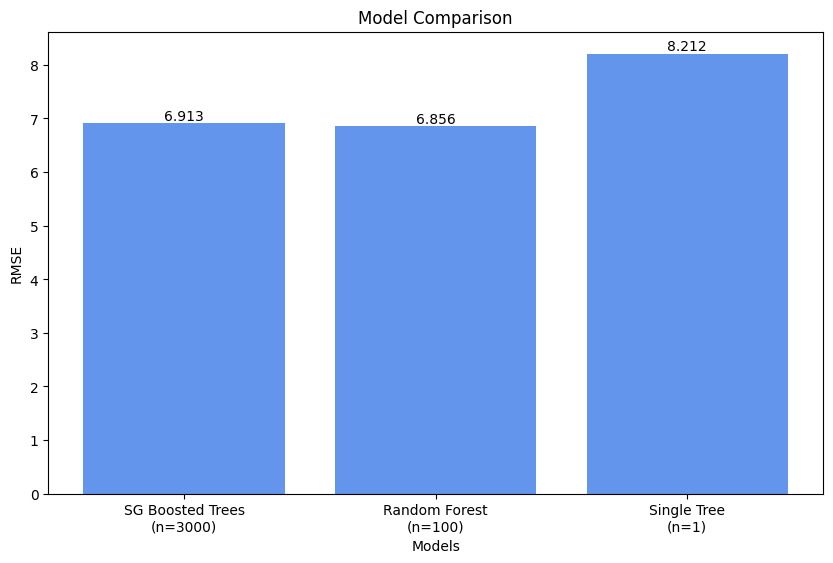

In [64]:
# create lists of RMSE values and models
rmse_values = [sgb_rmse, rf_rmse, tree_rmse]
models = ['SG Boosted Trees\n(n=3000)', 'Random Forest\n(n=100)', 'Single Tree\n(n=1)']

# create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, rmse_values, color=['cornflowerblue'])
plt.title('Model Comparison')
plt.xlabel('Models')
plt.ylabel('RMSE')

# add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()

Our best performing model was the random forest model, with a RMSE of 6.856. In normal English, a RMSE of 6.856 means that, on average, the predictions made by this model deviate from the actual DIC values by 6.856 micromoles per kilogram.

## Compare feature importance

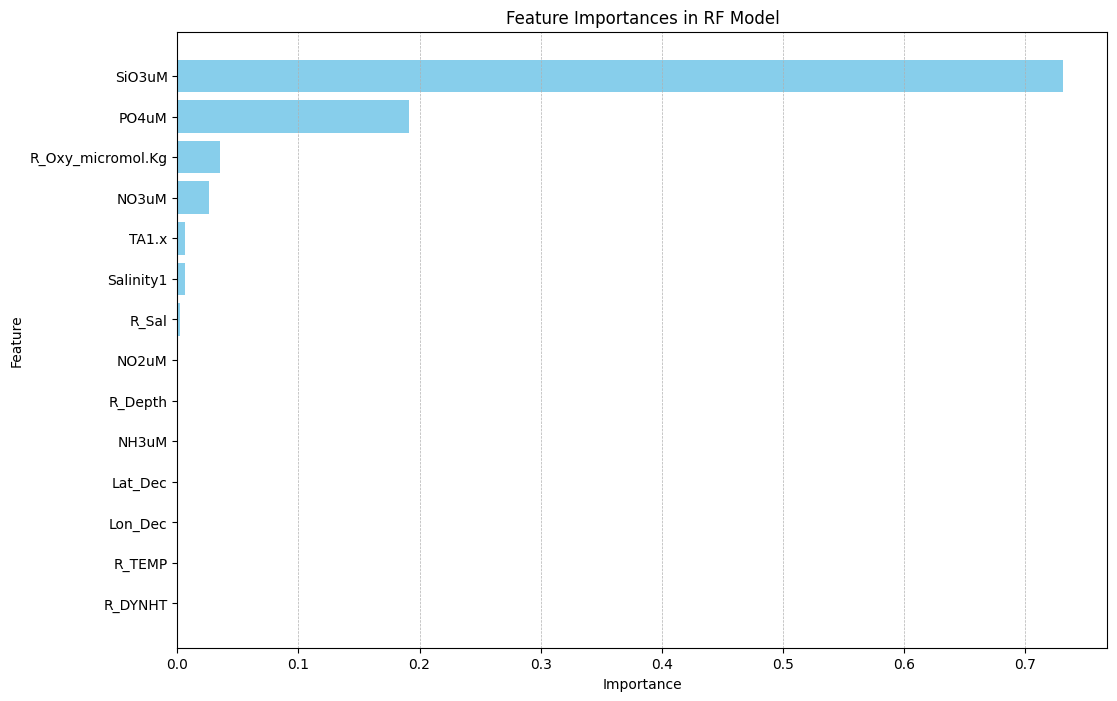

In [70]:
# extract importance of each feature from best version of model
importances = best_forest.named_steps['randomforestregressor'].feature_importances_

# create df to hold feature names and their importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# create plot
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in RF Model')
plt.grid(True, which='both', axis = 'x', linestyle='--', linewidth=0.5)

plt.show()

Here, we see that the most important feature for predicting DIC in the random forest model was 'SiO3uM', with a feature importance over 0.70. This was significantly higher than the second most important feature, 'PO4uM', which had a feature importance of close to 0.2.